## Plot the angular correlation function using the output from Angular_Correlation_Stable.py
## Here we plot:
### -- The correlation function
### -- The regression matrix
### -- bias vs. z

In [98]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
from scipy.optimize import curve_fit

In [99]:
#Generate the covariance matrix from the Jackknife file
def make_covariance(Jackfile, warray, RRarray):
    JK_xi = []
    size = float(len(warray))
    jkdat = open(Jackfile,'rw')
    #Read the header of the jackknife file and assign the number of jackknife resamples done for the sample
    jkhead = jkdat.readline()
    jknum= np.float(jkhead.split()[7])
    #Pull out the proper info from the file (RR,Xi,etc.) for each jackknife and put into array
    RRjk = np.zeros([jknum,int(size)])
    Xijk = np.zeros([jknum,int(size)])
    Thjk = np.zeros([jknum,int(size)])
    
    num=jkdat.readlines()
    row = 0
    k=0

    for j in range(len(num)):
        #At the end of a Jackknife run, I create a new line called 'STEP_DONE' which tells me that my next JK routine is running and separates the two.
        if num[j].split()[0] == 'STEP_DONE':
            row +=1
            k=0
        #For each of the JK runs, append the info into arrays
        else:
            Thjk[row,k] = float(num[j].split()[0])
            RRjk[row,k] = float(num[j].split()[3])
            Xijk[row,k] = float(num[j].split()[4])
            k+=1
    C = np.zeros([len(RRjk[0]),len(RRjk[0])])
    print len(RRjk[0])
    for m in range(len(RRjk[0])):
        for n in range(len(RRjk[0])):
            left = np.sqrt(np.asarray(RRjk[:,m])/RRarray[m])
            dwa = np.asarray(Xijk[:,m]) - warray[m]
            right = np.sqrt(np.asarray(RRjk[:,n])/RRarray[n])
            dwb = np.asarray(Xijk[:,n]) - warray[n]
            val = left*dwa*right*dwb
            C[m,n] = sum(val)
    return C

#Generate the covariance matrix from the Jackknife file
def make_JKxi(Jackfile, warray, RRarray):
    JK_xi = []
    size = float(len(warray))
    jkdat = open(Jackfile,'rw')
    #Read the header of the jackknife file and assign the number of jackknife resamples done for the sample
    jkhead = jkdat.readline()
    jknum= np.float(jkhead.split()[7])
    #Pull out the proper info from the file (RR,Xi,etc.) for each jackknife and put into array
    RRjk = np.zeros([jknum,int(size)])
    Xijk = np.zeros([jknum,int(size)])
    Thjk = np.zeros([jknum,int(size)])
    
    num=jkdat.readlines()
    row = 0
    k=0

    for j in range(len(num)):
        #At the end of a Jackknife run, I create a new line called 'STEP_DONE' which tells me that my next JK routine is running and separates the two.
        if num[j].split()[0] == 'STEP_DONE':
            row +=1
            k=0
        #For each of the JK runs, append the info into arrays
        else:
            Thjk[row,k] = float(num[j].split()[0])
            RRjk[row,k] = float(num[j].split()[3])
            Xijk[row,k] = float(num[j].split()[4])
            k+=1
    JK_xi.append(Xijk)   
    return JK_xi

#Compute chi square
def chisq(dat,mod,cmat):
    x = 0
    inverse = np.linalg.inv(cmat)
    for i in range(len(cmat)):
        for j in range(len(cmat)):
            df1 = dat[i]-mod[i]
            df2 = dat[j]-mod[j]
            #icv = cmat[i,j]**-1
            icv = inverse[i,j]
            x += df1*icv*df2
    return x

#Compute the regression matrix
def Regressmat(covar,theta):
    R= np.zeros([len(theta),len(theta)])
    for i in range(len(theta)):
        for j in range(len(theta)):
            R[i,j] = covar[i,j]/(np.sqrt(covar[i,i])*np.sqrt(covar[j,j]))
    return R

## Open The files here 

In [100]:
### SPLITTING BY Z Cuting at any imag
allz = '../Compute_correlation/Final_Angcor_Result_deccut.txt'
lowz = '../Compute_correlation/Final_Angcor_Result_deccut_lowz.txt'
highz = '../Compute_correlation/Final_Angcor_Result_deccut_highz.txt'

allzJK = '../Compute_correlation/Final_Angcor_Result_deccut_JK.txt'
lowzJK = '../Compute_correlation/Final_Angcor_Result_deccut_lowz_JK.txt'
highzJK = '../Compute_correlation/Final_Angcor_Result_deccut_highz_JK.txt'

datfiles = [allz,lowz,highz]
JKfiles = [allzJK,lowzJK,highzJK]


## Pull out the relevant information (theta, correlation function, RR array)

In [101]:
#Loop over the data files list to open and plot the correlation function
separation = []
wnames = []
RRnames = []
DDnames = []
DRnames = []
for infile in datfiles:
    fileopen = open(infile,'rw')
    header = fileopen.readline()
    data = fileopen.readlines() 

    th = []
    w = []
    RR = []
    DD = []
    DR = []
    for i in range(len(data)):
        t = float(data[i].split()[0]) #Theta
        x = float(data[i].split()[4]) #w(theta) 
        rr = float(data[i].split()[3]) #RR 
        dd = float(data[i].split()[1]) #DD
        dr = float(data[i].split()[2]) #DR 
        w.append(x)
        RR.append(rr)
        DD.append(dd)
        DR.append(dr)
        th.append(t)
    #Put the w and RR values into an array to call for Jackknife calculation
    wnames.append(w)
    RRnames.append(RR)
    DDnames.append(DD)
    DRnames.append(DR)
    separation.append(th)

## Run the JK error routine to make the covariance matrix for each input file
## Compute the regression matrix from the covariance

In [102]:
#Compute Jackknife errors from the counts information
sigma = []
covmat = []
for h in range(len(JKfiles)):
    covariance = make_covariance(JKfiles[h], wnames[h], RRnames[h])
    sigma.append(np.diag(covariance))
    covmat.append(covariance)

#Compute the regression matrix
regmat = []
for h in range(len(wnames)):
    regmat.append(Regressmat(covmat[h],th))

print np.shape(regmat)


21
21
21
(3, 21, 21)


/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [103]:
#Get jackknife w's
JK_xi = []
for h in range(len(JKfiles)):
    jk = make_JKxi(JKfiles[h], wnames[h], RRnames[h])
    JK_xi.append(jk[0])

print np.shape(JK_xi)
print len(separation[0])


(3, 10, 21)
21


/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:50: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [104]:
#Print values for latex table
for i in range(len(DDnames[0])):
    #print separation[0][i], '&', DDnames[0][i], '&', DRnames[0][i], '&', RRnames[0][i], '&', wnames[0][i], '&', sigma[0][i]
    print '%.3f & %.1i & %.1i & %.1i & %.3f & %.4f \\\\'%(separation[0][i],DDnames[0][i],DRnames[0][i],RRnames[0][i],wnames[0][i],sigma[0][i]**0.5)

0.050 & 0 & 25 & 1274 & -0.303 & 0.2176 \\
0.076 & 2 & 111 & 2902 & -0.780 & 0.7756 \\
0.116 & 2 & 212 & 6902 & -0.720 & 0.2896 \\
0.175 & 14 & 451 & 15570 & 0.068 & 0.3773 \\
0.266 & 42 & 1055 & 34902 & 0.319 & 0.3113 \\
0.403 & 68 & 2388 & 79948 & -0.046 & 0.1694 \\
0.611 & 236 & 5511 & 183314 & 0.423 & 0.1821 \\
0.927 & 406 & 12420 & 413576 & 0.088 & 0.0722 \\
1.405 & 1056 & 28337 & 929514 & 0.228 & 0.0687 \\
2.131 & 2040 & 64303 & 2113066 & 0.043 & 0.0299 \\
3.231 & 4764 & 144390 & 4787384 & 0.094 & 0.0307 \\
4.899 & 10618 & 329437 & 10846716 & 0.062 & 0.0098 \\
7.428 & 23054 & 745067 & 24533352 & 0.019 & 0.0084 \\
11.262 & 51706 & 1671110 & 55122880 & 0.021 & 0.0071 \\
17.075 & 113240 & 3718228 & 122561080 & 0.004 & 0.0054 \\
25.889 & 247660 & 8114770 & 267724540 & 0.007 & 0.0024 \\
39.253 & 521990 & 17156420 & 566301910 & 0.004 & 0.0024 \\
59.516 & 1034402 & 34009772 & 1123151204 & 0.005 & 0.0020 \\
90.237 & 1799340 & 59561796 & 1973443116 & 0.001 & 0.0020 \\
136.818 & 2492092 & 

In [105]:
print wnames[0]
print list(sigma[0])

[-0.302669221639, -0.779878470719, -0.719790451903, 0.0677418380312, 0.31914103111, -0.0457896674054, 0.422636146497, 0.0879657998424, 0.227855966011, 0.0434732331043, 0.0941515431781, 0.0622598997844, 0.0192236632271, 0.0209146064896, 0.00397960885284, 0.00703285572035, 0.00436364169761, 0.00450194016714, 0.000933232623371, 0.00212224503155, 0.00128364155321]
[0.047351465693274128, 0.60160338351197118, 0.083853140760825021, 0.14235810964241949, 0.096892664456219108, 0.028692499544471381, 0.033174732082903356, 0.0052121022953761026, 0.004724150502025291, 0.00089629523661271908, 0.00094463800821812727, 9.6686889295645453e-05, 7.0184445385458946e-05, 4.978904173885681e-05, 2.9447622268879509e-05, 5.6300015425245787e-06, 5.5968705523112817e-06, 3.9017756129126032e-06, 3.8606520665412385e-06, 3.5891723451341186e-06, 2.5820230572277491e-06]


## Read in the Model results from Limber_MCint_Stable.py and fit

In [217]:
#Following Limber was computed with cosmology (H0,oM,oL)=(70 0.275 0.725)

##This mclimber was done for allz 2.9<2<5.2
#mclimber_all = [0.0018901069830166064, 0.0015469541773802007, 0.0012618003172005974, 0.0010646848849014826, 0.00092659609065711736, 0.0008121011076479759, 0.00069717733505905916, 0.00057620099028505515, 0.00045441356648772189, 0.0003334100976949317, 0.00022407216949898401, 0.00013460720655439581, 6.8890660458582111e-05, 2.8945118539565589e-05, 8.5993807832771192e-06, 2.6124134574857943e-06, -2.353262803259482e-06, -1.0507113239217212e-06, -4.7148295416947918e-07, -9.8152287015064401e-08]
mclimber_all = [0.0018132126094168957, 0.0017105082924047138, 0.0014967771368198301, 0.0011698711939894665, 0.00096561594145769313, 0.00088264124151502291, 0.00075754416871593475, 0.00061874618344352067, 0.0004899313948145415, 0.00035852922045630573, 0.00024214487991075338, 0.00014493374013188016, 7.5400067230269098e-05, 3.0702250048288822e-05, 9.1038044037598588e-06, 2.5584804703916217e-06, -2.0130116643295776e-06, -8.8664135463053354e-07, -1.3733851572699093e-07, 7.7941022052885505e-08]
#Lowz mclimber 2.9<2<3.4
#mclimber_low = [0.0044477998043758677, 0.0036112654673913242, 0.0029158044391958868, 0.0024111455996782979, 0.0020569973732013588, 0.0018017839702771194, 0.0015315070041019771, 0.0012691931810851107, 0.0010075833381944822, 0.00075434181685649223, 0.00050795884326507547, 0.0002965548495608406, 0.00016764802583984481, 7.3381272557181558e-05, 1.371220983010611e-05, 5.5506979609669511e-06, -1.4020592353893683e-05, 2.2652902066516834e-06, 2.310737462803802e-06, 4.2790243898727134e-07]
mclimber_low = [0.0047036222794496685, 0.004434089448563946, 0.0038684678458308286, 0.0029817263313698049, 0.0023900646533136171, 0.0022034731957067456, 0.0018879805522201447, 0.0015307598219191445, 0.0012193391011925583, 0.00089806162527305525, 0.0006091440585769592, 0.00036849201401008768, 0.00019208012036897734, 7.9764907079234713e-05, 2.3555222043239187e-05, 8.5542359843671128e-06, -6.5124310259897249e-06, -2.0025264825362079e-06, -1.1692192230985719e-06, -6.9125277531392635e-07]
#This mclimber was done for 3.4<z<5
#mclimber_high = [0.0021612146984227114, 0.0017915613501401173, 0.0015090379209649599, 0.0013335946010651777, 0.0011883879587747991, 0.0010389364077332405, 0.0008905878071767976, 0.00072628713786955968, 0.00058158640964684318, 0.00042241571718415813, 0.00027336529427609223, 0.00016511117031507011, 8.1855335072549657e-05, 3.8284627330113334e-05, 1.1226301215780448e-05, 5.0014575973491967e-06, -2.5621990019662722e-06, -1.1988011477889577e-07, -2.6253218073191083e-06, -2.8749589456269404e-06]
mclimber_high = [0.0022529517590044938, 0.0021280436475443168, 0.0018731349354724374, 0.0015033947078234348, 0.0013070363461209996, 0.0011766368407685472, 0.0010140398851336263, 0.00083560744525899085, 0.00065508092975343803, 0.00047837963299693522, 0.0003187878517245088, 0.0001885268241591017, 9.5947162744095565e-05, 3.876918723162803e-05, 1.0394048795964464e-05, 3.7806009976488573e-06, -3.1705205023784285e-06, -1.3079909197198175e-06, -1.1571078800356848e-06, 2.4679274288594045e-07]

limbera = np.asarray(mclimber_all)*np.pi / 0.7**3 
limberl = np.asarray(mclimber_low)*np.pi / 0.7**3 
limberh = np.asarray(mclimber_high)*np.pi / 0.7**3 

#Interpolate Limber (you get the same function back) to plug in any z in the range (as opposed to set z values)
Limbera = interpolate.interp1d(np.logspace(-1.3,2.5,20),limbera)
Limberl = interpolate.interp1d(np.logspace(-1.3,2.5,20),limberl)
Limberh = interpolate.interp1d(np.logspace(-1.3,2.5,20),limberh)




In [218]:
#Fit Limber to wtheta to get ideal bias value
def L(Limb,b):
    l = b**2 * Limb
    return l

gdx = (np.asarray(separation[0])>1) & (np.asarray(separation[0])<30)

allzbias, allzcov = curve_fit(L, np.asarray(Limbera(separation[0])[gdx]), np.asarray(wnames[0])[gdx], sigma = sigma[0][gdx]**0.5,absolute_sigma=True)
lowzbias, lowzbcov = curve_fit(L, np.asarray(Limberl(separation[1])[gdx]), np.asarray(wnames[1])[gdx], sigma = sigma[1][gdx]**0.5,absolute_sigma=True)
highzbias, highzcov = curve_fit(L, np.asarray(Limberh(separation[2])[gdx]), np.asarray(wnames[2])[gdx], sigma = sigma[2][gdx]**0.5,absolute_sigma=True)

print 'Biases, no contamination:'
print 'allz=', allzbias
print 'lowz=', lowzbias
print 'highz=', highzbias

La = L(Limbera(separation[0]),allzbias)
Ll = L(Limberl(separation[1]),lowzbias)
Lh = L(Limberh(separation[2]),highzbias)

limb_fit = [La,Ll,Lh]

Biases, no contamination:
allz= [ 4.68511453]
lowz= [ 3.13936632]
highz= [ 5.10013174]


In [225]:
#Stellar contamination fit using the efficiency of the algorithm (0.93) and the correlation function of stars in the field at large scale (0.09)

def stellar_cont(Limb,b,e):
    w_cont = (0.86**2 *b**2 * Limb) + (0.09*(1-0.86)**2) + e
    #w_cont = (0.93**2 *b**2 * Limb) + (0.09*(1-0.93)**2) + e
    return w_cont

bdx = (np.asarray(separation[0])>1) & (np.asarray(separation[0])<30)

allzb, allzcov = curve_fit(stellar_cont, np.asarray(Limbera(separation[0])[bdx]), np.asarray(wnames[0])[bdx], sigma = sigma[0][bdx]**0.5,absolute_sigma=True, bounds=([0,0.],[np.inf,9.9e-3]))
lowzb, lowzcov = curve_fit(stellar_cont, np.asarray(Limberl(separation[1])[bdx]), np.asarray(wnames[1])[bdx], sigma = sigma[1][bdx]**0.5,absolute_sigma=True, bounds=([0,0.],[np.inf,9.9e-3]))
highzb, highzcov = curve_fit(stellar_cont, np.asarray(Limberh(separation[2])[bdx]), np.asarray(wnames[2])[bdx], sigma = sigma[2][bdx]**0.5,absolute_sigma=True, bounds=([0,0.],[np.inf,9.9e-3]))

Las = stellar_cont(Limbera(separation[0]),allzb[0],allzb[1])
Lls = stellar_cont(Limberl(separation[1]),lowzb[0],lowzb[1])
Lhs = stellar_cont(Limberh(separation[2]),highzb[0],highzb[1])

print 'Biases and cross correlations, with contamination:'
print 'allz=', allzb
print 'allz error=',allzcov[0][0]
print 'allz epsilon error=',allzcov[1][1]

print 'lowz=', lowzb
print 'lowz error=', lowzcov[0][0]

print 'highz=', highzb
print 'highz error=', highzcov[0][0]

stcont_limb = [Las,Lls,Lhs]

Biases and cross correlations, with contamination:
allz= [  5.26145740e+00   1.18160737e-04]
allz error= 0.170352323341
allz epsilon error= 6.04241898726e-06
lowz= [  3.52813933e+00   4.30274727e-19]
lowz error= 0.293393334499
highz= [ 5.13505946  0.0099    ]
highz error= 0.493583361208


In [209]:
#Fit a power law
def powlaw(theta,t0,g):
    w_cont = (theta/t0)**(-g)
    return w_cont

bdx = (np.asarray(separation[0])>1) & (np.asarray(separation[0])<30)

allpow, apowcov = curve_fit(powlaw, np.asarray(separation[0])[bdx], np.asarray(wnames[0])[bdx], sigma = sigma[0][bdx]**0.5,absolute_sigma=True)
lowpow, lpowcov = curve_fit(powlaw, np.asarray(separation[1])[bdx], np.asarray(wnames[1])[bdx], sigma = sigma[1][bdx]**0.5,absolute_sigma=True)
highpow, hpowcov = curve_fit(powlaw, np.asarray(separation[2])[bdx], np.asarray(wnames[2])[bdx], sigma = sigma[2][bdx]**0.5,absolute_sigma=True)
apfit = allpow
lpfit = lowpow
hpfit = highpow
print 'theta0, gamma:'
print allpow
print apowcov
print lowpow
print lpowcov
print highpow
print hpowcov

allpow = powlaw(separation[0],allpow[0],allpow[1])
lowpow = powlaw(separation[1],lowpow[0],lowpow[1])
highpow = powlaw(separation[1],highpow[0],highpow[1])

pow_fit = [allpow,lowpow,highpow]

theta0, gamma:
[ 0.28538609  1.10337564]
[[ 0.01151028  0.01389231]
 [ 0.01389231  0.01821102]]
[ 0.57219404  1.35853727]
[[ 0.04463597  0.04351255]
 [ 0.04351255  0.04917009]]
[ 0.1596986   0.79523201]
[[ 0.01351268  0.01661976]
 [ 0.01661976  0.02186891]]


In [210]:
#Chi square of the power law fits
#Need to cast the fitting range to the full matrix
#define a boolean array with the fitting parameters
gdx = (np.asarray(th)>1) & (np.asarray(th)<30)
#Change the boolean array to binary; 0=False
int1 = np.asarray(gdx*1)
#Create a binary matrix which reflect where True and False are
gdx2 = int1[:,np.newaxis] * int1
#Convert back to a matrix of booleans
gdx3 = (gdx2 == 1)

chi_pow = []
for h in range(len(wnames)):
    chip = chisq(np.asarray(wnames[h])[gdx],pow_fit[h][gdx],covmat[h][gdx3].reshape(len(pow_fit[h][gdx]),len(pow_fit[h][gdx])))
    chi_pow.append(chip)

    
print 'Power law chi^2:', np.asarray(chi_pow)/(len(lowpow[gdx])-2.0), 'for %i DOF'% (len(lowpow[gdx])-2.0)


Power law chi^2: [ 38.82985339   0.85260743   4.36554925] for 6 DOF


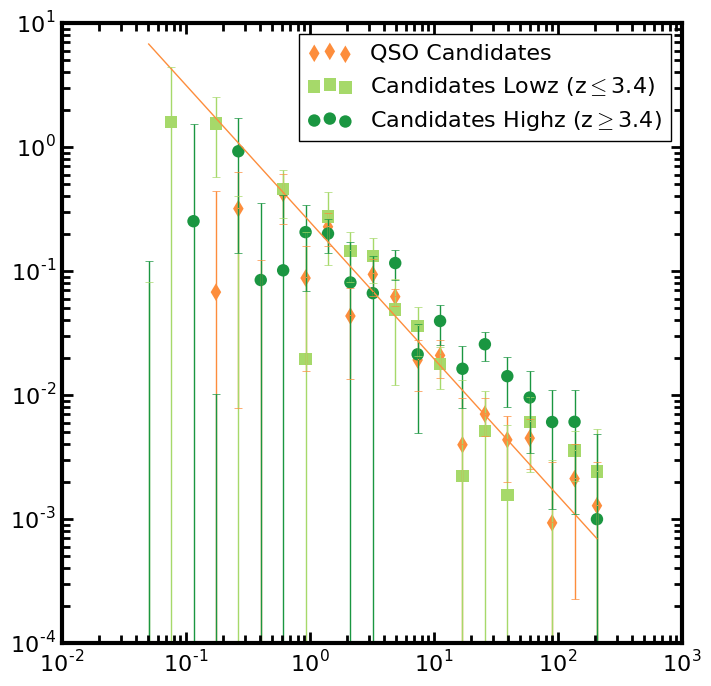

In [211]:
plt.figure(1,figsize = (8,8))
plt.plot(separation[0],allpow,color='#fd8d3c')
#plt.plot(separation[1],powlaw(separation[1],lowpow[0],lowpow[1]),color='#a6d96a')
#plt.plot(separation[2],powlaw(separation[2],highpow[0],highpow[1]),color = '#1a9641')

plt.scatter(separation[0],wnames[0],s = 80,color='#fd8d3c', marker = 'd',edgecolor='None',label=r'QSO Candidates')
plt.errorbar(separation[0],wnames[0],yerr=sigma[0]**0.5,elinewidth=1,fmt=',',color='#fd8d3c')

plt.scatter(separation[1]+0.0*np.asarray(separation[1]),wnames[1],s = 80,color='#a6d96a',marker = 's', edgecolor='None',label=r'Candidates Lowz (z$\leq$3.4)')
plt.errorbar(separation[1]+0.0*np.asarray(separation[1]),wnames[1],yerr=sigma[1]**0.5,elinewidth=1,fmt=',',color='#a6d96a')

plt.scatter(separation[2]+0.0*np.asarray(separation[2]),wnames[2],s = 80,color = '#1a9641', marker = 'o',edgecolor='None',label='Candidates Highz (z$\geq$3.4)')
plt.errorbar(separation[2]+0.0*np.asarray(separation[2]),wnames[2],yerr=sigma[2]**0.5,elinewidth=1,fmt=',',color='#1a9641')

plt.ylim(1e-4,1e1)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

## Compute the reduced chi square

In [212]:
#Need to cast the fitting range to the full matrix
#define a boolean array with the fitting parameters
gdx = (np.asarray(th)>1) & (np.asarray(th)<30)
#Change the boolean array to binary; 0=False
int1 = np.asarray(gdx*1)
#Create a binary matrix which reflect where True and False are
gdx2 = int1[:,np.newaxis] * int1
#Convert back to a matrix of booleans
gdx3 = (gdx2 == 1)

chi_limb = []
chi_stctm = []
for h in range(len(wnames)):
    chi1 = chisq(np.asarray(wnames[h])[gdx],limb_fit[h][gdx],covmat[h][gdx3].reshape(len(limb_fit[h][gdx]),len(limb_fit[h][gdx])))
    chi2 = chisq(np.asarray(wnames[h])[gdx],stcont_limb[h][gdx],covmat[h][gdx3].reshape(len(stcont_limb[h][gdx]),len(stcont_limb[h][gdx])))
    chi_limb.append(chi1)
    chi_stctm.append(chi2)

    
print len(Lls[gdx])
print 'No stellar contamination chi^2:', np.asarray(chi_limb)/(len(Lls[gdx])-1.0), 'for %i DOF'% (len(Lls[gdx])-1.0)
print 'Stellar contamination chi^2:',np.asarray(chi_stctm)/(len(Lls[gdx])-2.0), 'for %i DOF'% (len(Lls[gdx])-2.0)

8
No stellar contamination chi^2: [ 28.63529063   5.52445416  11.20207277] for 7 DOF
Stellar contamination chi^2: [ 31.88991892   7.04448007   5.2735188 ] for 6 DOF


## Set up/Plot the correlation function

In [203]:
#open the angular results from the SHEN 2007 run
shen = './Shen_Angcor.txt'
shenjk = './Shen_Angcor_JK.txt'

datfiles2 = [shen]
JKfiles2 = [shenjk]


#Loop over the data files list to open and plot the correlation function
separation2 = []
wnames2 = []
RRnames2 = []

for infile in datfiles2:
    fileopen = open(infile,'rw')
    header = fileopen.readline()
    data = fileopen.readlines() 

    th = []
    w = []
    RR = []
    
    for i in range(len(data)):
        t = float(data[i].split()[0]) #Theta
        x = float(data[i].split()[4]) #w(theta) 
        rr = float(data[i].split()[3]) #RR 
       
        w.append(x)
        RR.append(rr)
        
        th.append(t)
    #Put the w and RR values into an array to call for Jackknife calculation
    wnames2.append(w)
    RRnames2.append(RR)
   
    separation2.append(th)

#Compute Jackknife errors from the counts information
sigma2 = []
covmat2 = []
for h in range(len(JKfiles2)):
    covariance = make_covariance(JKfiles[h], wnames[h], RRnames[h])
    sigma2.append(np.diag(covariance))
    covmat2.append(covariance)

#Compute the regression matrix
regmat2 = []
for h in range(len(wnames2)):
    regmat2.append(Regressmat(covmat2[h],th))

print np.shape(regmat2)


#Get jackknife w's
JK_xi2 = []
for h in range(len(JKfiles2)):
    jk = make_JKxi(JKfiles2[h], wnames2[h], RRnames2[h])
    JK_xi2.append(jk[0])

print np.shape(JK_xi2)
print len(separation2[0])


sth = separation2[0]
sw = wnames2[0]
sjk= sigma2[0]

print len(sth),len(sw),len(sjk)

21
(1, 21, 21)
(1, 10, 21)
21
21 21 21


/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:50: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/johntimlin/anacond

In [162]:
#BOSS wtheta which I computed using a subset of Eft 2015 
Bth = [0.050323978983, 0.0763011640511, 0.115687744753, 0.175405637024, 0.265949842531, 0.403232871773, 0.611381256445, 0.926975618552, 1.40547945874, 2.13098647839, 3.23099945918, 4.89883798472, 7.42761300449, 11.2617390321, 17.0750368861, 25.8891529834, 39.2531065478, 59.5155188986, 90.2373672122, 136.817801341, 207.443006619]
Bwt = [-0.399949636665, -0.139493890308, -0.446243530879, 0.76311340272, -0.525602284033, -0.573893771779, -0.470477229437, -0.295626322384, 0.207851198524, 0.18424850005, 0.10315515435, 0.0983282856195, 0.0654036946897, 0.0349133960631, 0.0209796601689, 0.0199293887951, 0.014989772678, 0.0125284121898, 0.008932733109, 0.00654631771702, 0.00457786274708]

In [163]:
#The He 2017 points for small scales
heth = [2.05,3.25,5.15,8.15,12.92,20.48,32.46,51.45,81.55,129.24,204.84,324.65,514.53,815.48]
heth = np.asarray(heth)/60.

#Luminous sample
hew = [0,-1,0,-1,-0.33,1.96,-0.85,0.53,0.21,0.15,0.07,-0.07,0.05,-0.005]
hewe= [0,9.76,8.53,1.69,0.86,2.11,0.15,0.32,0.27,0.14,0.08,0.04,0.07,0.03]
#Less Luminous sample
hewll = [0,3.25,2.86,1.58,1.96,-0.11,0.36,-0.002,0.13,0.14,0.06,0.06,0.04,0.02]
hewell = [0,8.74,2.51,1.91,1.79,0.47,0.26,0.18,0.13,0.09,0.04,0.04,0.02,0.02]


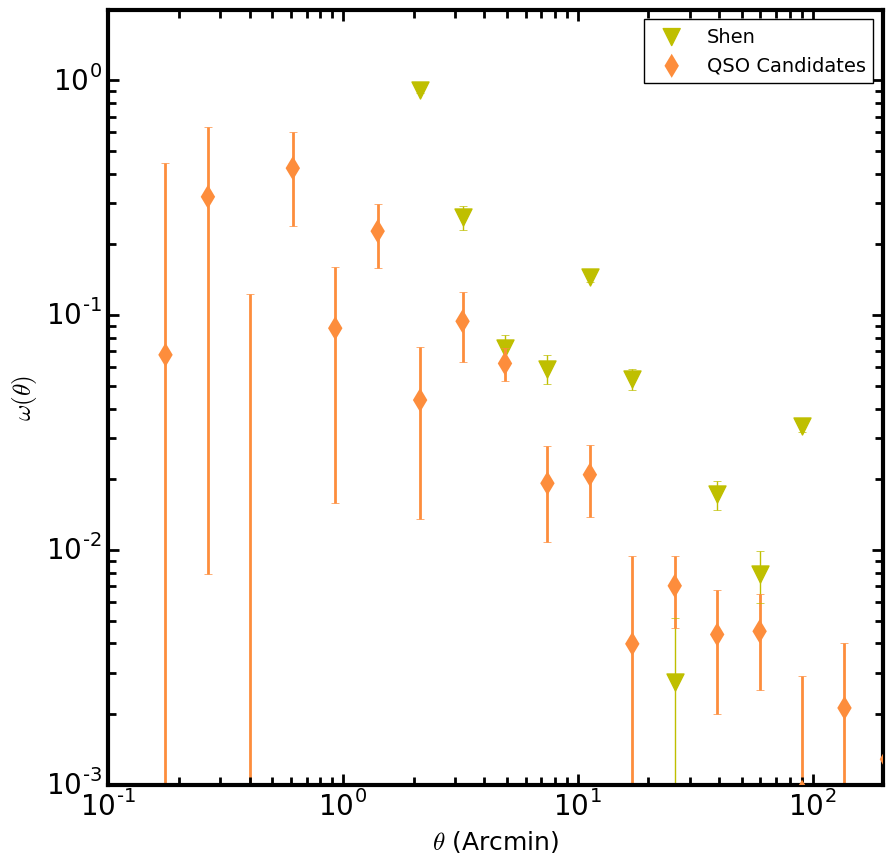

In [164]:
#Plotting Parameters (Replace with Group code call!)
params = {'legend.fontsize': 16, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':8, 'xtick.minor.size':6, 'ytick.major.size':8, 'ytick.minor.size':6}
plt.rcParams.update(params)
plt.rc("axes", linewidth=3.0)

plt.figure(2,figsize=[10,10])
'''
#BOSS
plt.scatter(Bth,Bwt,s=150,marker = '*', color = 'k',label = r'BOSS $2.2\leq \mathrm{z}\leq 2.8$')
#lowz comparison to BOSS
plt.scatter(separation[1],wnames[1],s = 80,color='#a6d96a',marker = 's', edgecolor='None',label=r'Low-z (z$\leq$3.4)')
plt.errorbar(separation[1],wnames[1],yerr=sigma[1]**0.5,elinewidth=1,fmt=',',color='#a6d96a')
plt.plot(separation[1],Lls,linewidth = 2,color = '#a6d96a',label='Low-z bias=%0.2f'%lowzb[0])
plt.plot(separation[1],lowpow,color='#a6d96a',linewidth = 2, linestyle = ':',dashes = (2,2,2,2),label = r'$\theta_0$ =%0.2f ; $\delta$ = %0.2f '%(lpfit[0],lpfit[1]))
'''

plt.scatter(sth,sw,s=150,marker = 'v', color = 'y',label = r'Shen')
plt.errorbar(sth,sw,yerr=sjk**0.5,elinewidth=1,fmt=',',color='y')

#He luminous
#plt.scatter(heth,hew,s = 80,color='c', marker = '^',edgecolor='None',label='He 2017')
#plt.errorbar(heth,hew,yerr=hewe,elinewidth=1,fmt=',',color='c')
'''
#He less luminous
plt.scatter(heth,hewll,s = 150,color='c', marker = '^',edgecolor='None',label='He 2017')
plt.errorbar(heth,hewll,yerr=hewell,elinewidth=1,fmt=',',color='c')
plt.plot(heth,6.53/60.**0.86*heth**-0.86,color='c',linewidth = 2, linestyle = '--',dashes = (4,2,4,2))

#highz candidates comparison to HE
plt.scatter(separation[2],wnames[2],s = 80,color = '#1a9641', marker = 'o',edgecolor='None',label='High-z (z$\geq$3.4)')
plt.errorbar(separation[2],wnames[2],yerr=sigma[2]**0.5,elinewidth=1,fmt=',',color='#1a9641')
plt.plot(separation[1],Lhs,linewidth = 2,color = '#1a9641',label='High-z bias=%0.2f'%highzb[0])
plt.plot(separation[1],highpow,color='#1a9641',linewidth = 2, linestyle = ':',dashes = (2,2,2,2),label = r'$\theta_0$ =%0.2f ; $\delta$ = %0.2f '%(hpfit[0],hpfit[1]))
'''

#Plot the candidates
plt.scatter(separation[0],wnames[0],s = 150,color='#fd8d3c', marker = 'd',edgecolor='None',label=r'QSO Candidates',zorder = 100)
plt.errorbar(separation[0],wnames[0],yerr=sigma[0]**0.5,elinewidth=2,fmt=',',color='#fd8d3c')


#No Stellar contamination in fit
#plt.plot(separation[0],La,linestyle = '--', dashes = (8,3,8,3),linewidth = 2,color = '#fd8d3c',label='DM model b=%0.2f'%allzbias[0])

#With Stellar contamination in fit
#plt.plot(separation[0],Las,linewidth = 2,color = '#fd8d3c')#,label = 'Stellar contamination\n b=%0.2f'%allzb[0])

#Power law fit
#plt.plot(separation[0],allpow,color='#fd8d3c',linewidth = 2, linestyle = ':',dashes = (2,2,2,2))#,label = r'$\theta_0$ =%0.2f ; $\delta$ = %0.2f '%(apfit[0],apfit[1]))
'''
for i in range(len(JK_xi[0])): 
    if i == len(JK_xi[0])-1:
        plt.plot(separation[0],JK_xi[0][i],color='k',alpha = 0.15, linewidth = 1,label='Jackknife samples')
    else:
        #plt.scatter(separation[0],JK_xi[0][i],s = 15,color='k',alpha = 0.5, marker = 's',edgecolor='None')
        plt.plot(separation[0],JK_xi[0][i],color='k',alpha = 0.15, linewidth = 1)
'''   

#plt.axvline(4)
#plt.axvline(25)
plt.xlim(0.1,200)
plt.ylim(10**-3,2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\theta$ (Arcmin)',fontsize = 18)
plt.ylabel(r'$\omega (\theta)$',fontsize = 18)
plt.legend(fontsize = 14, scatterpoints=1)
#plt.savefig('./Paper_corrfunc.pdf')

plt.show()

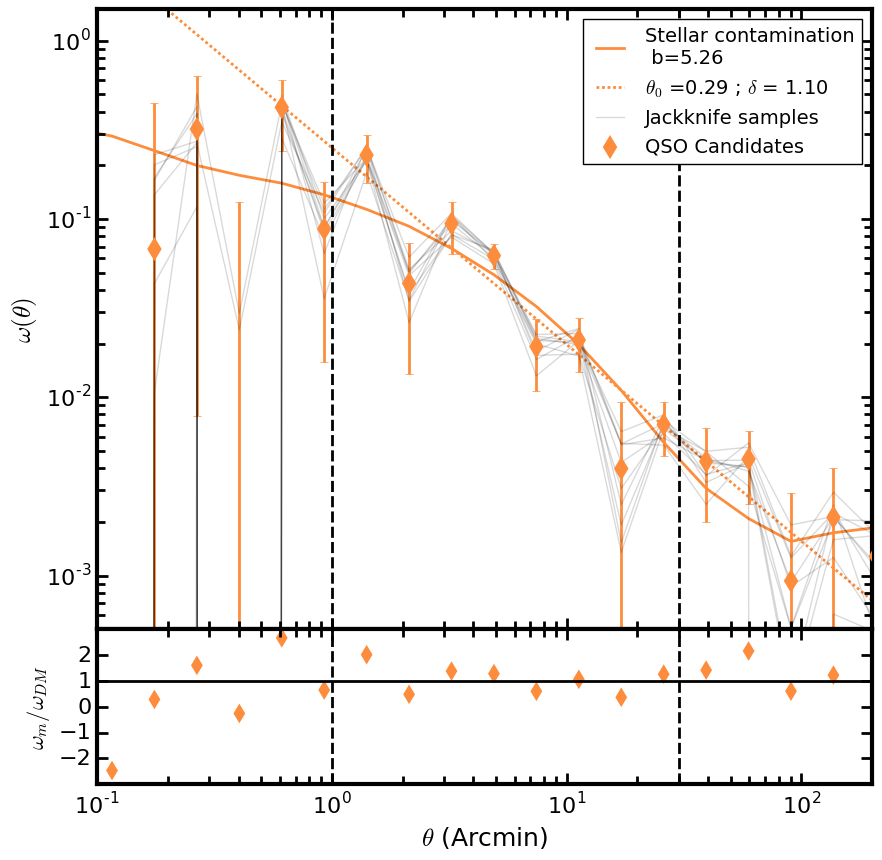

In [227]:
from matplotlib import gridspec
#Plot for paper
fig = plt.figure(3,figsize = (10,10))
gs = gridspec.GridSpec(2, 1, height_ratios=[0.8,0.2])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharex = ax0)

plt.axes(ax0)
plt.scatter(separation[0],wnames[0],s = 150,color='#fd8d3c', marker = 'd',edgecolor='None',label=r'QSO Candidates',zorder = 100)
plt.errorbar(separation[0],wnames[0],yerr=sigma[0]**0.5,elinewidth=2,fmt=',',color='#fd8d3c')

#No Stellar contamination in fit
#plt.plot(separation[0],La,linestyle = '--', dashes = (8,3,8,3),linewidth = 2,color = '#fd8d3c',label='DM model b=%0.2f'%allzbias[0])

#With Stellar contamination in fit
plt.plot(separation[0],Las,linewidth = 2,color = '#fd8d3c',label = 'Stellar contamination\n b=%0.2f'%allzb[0])

#Power law fit
plt.plot(separation[0],allpow,color='#fd8d3c',linewidth = 2, linestyle = ':',dashes = (2,2,2,2),label = r'$\theta_0$ =%0.2f ; $\delta$ = %0.2f '%(apfit[0],apfit[1]))

for i in range(len(JK_xi[0])): 
    if i == len(JK_xi[0])-1:
        plt.plot(separation[0],JK_xi[0][i],color='k',alpha = 0.15, linewidth = 1,label='Jackknife samples')
    else:
        #plt.scatter(separation[0],JK_xi[0][i],s = 15,color='k',alpha = 0.5, marker = 's',edgecolor='None')
        plt.plot(separation[0],JK_xi[0][i],color='k',alpha = 0.15, linewidth = 1)

        ax0.set_ylim(5e-4,1.5)

ax0.axvline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax0.axvline(30,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax0.set_yscale('log')
ax0.set_ylabel(r'$\omega (\theta)$',fontsize = 18)
ax0.legend(fontsize = 14, scatterpoints=1)

plt.axes(ax1)
plt.axhline(1,linewidth = 2, color = 'k')
plt.axvline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.axvline(30,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.scatter(separation[0],np.asarray(wnames[0])/Las,s = 100,color='#fd8d3c', marker = 'd',edgecolor='None' )
ax1.yaxis.set_ticks([-2,-1,0,1,2])
ax1.set_ylabel(r'$\omega_m / \omega_{DM}$', fontsize = 16)

plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.xlim(0.1,200)
plt.xscale('log')
plt.xlabel(r'$\theta$ (Arcmin)',fontsize = 18)

#plt.savefig('./SpIES_corrfunc_only.pdf',bbox_inches='tight')

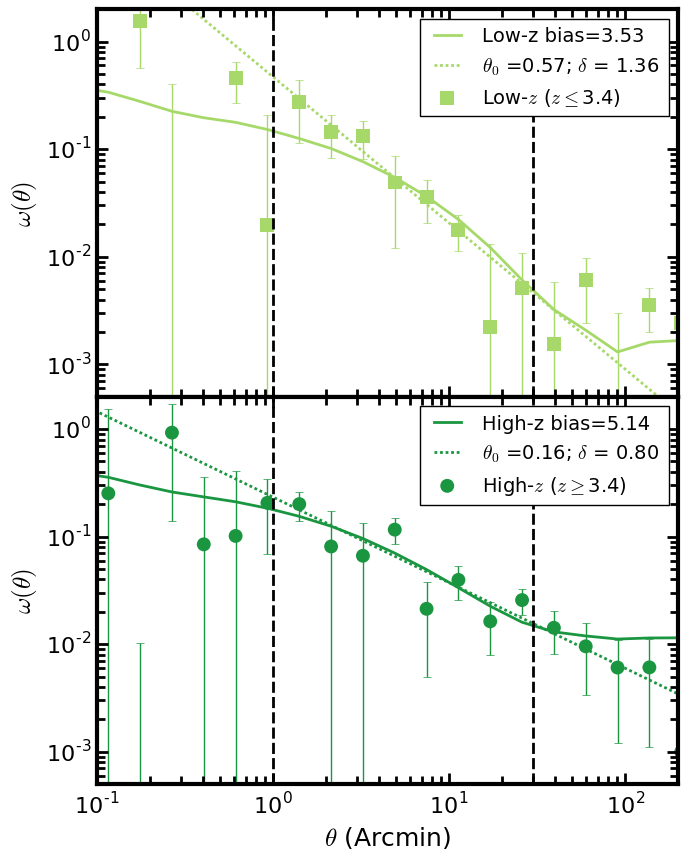

In [271]:
##Plot the different redshifts
from matplotlib import gridspec

#Plot for paper
fig = plt.figure(6,figsize = (15,10))
gs = gridspec.GridSpec(2, 1, width_ratios=[1,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharex = ax0)

#BOSS
#ax0.scatter(Bth,Bwt,s=100,marker = '*', color = 'k',label = r'BOSS $2.2\leq z\leq 2.8$')
#lowz comparison to BOSS
ax0.scatter(separation[1],wnames[1],s = 100,color='#a6d96a',marker = 's', edgecolor='None',label=r'Low-$z$ ($z\leq$3.4)')
ax0.errorbar(separation[1],wnames[1],yerr=sigma[1]**0.5,elinewidth=1,fmt=',',color='#a6d96a')
ax0.plot(separation[1],Lls,linewidth = 2,color = '#a6d96a',label='Low-z bias=%0.2f'%lowzb[0])
#ax0.plot(separation[1],Ll,linewidth = 2,color = '#a6d96a',label='Low-z bias=%s'%lowzbias)
ax0.plot(separation[1],lowpow,color='#a6d96a',linewidth = 2, linestyle = ':',dashes = (2,2,2,2),label = r'$\theta_0$ =%0.2f; $\delta$ = %0.2f '%(lpfit[0],lpfit[1]))

ax0.axvline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax0.axvline(30,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')

ax0.set_ylim(5*10**-4,2)
ax0.set_yscale('log')
ax0.set_ylabel(r'$\omega (\theta)$',fontsize = 18)
ax0.legend(fontsize = 14, scatterpoints=1)


#He less luminous
#ax1.scatter(heth,hewll,s = 100,color='c', marker = '^',edgecolor='None',label='HSC $3\leq z\leq 4$')
#ax1.errorbar(heth,hewll,yerr=hewell,elinewidth=1,fmt=',',color='c')
#ax1.plot(heth,6.53/60.**0.86*heth**-0.86,color='c',linewidth = 2, linestyle = '--',dashes = (4,2,4,2))

#highz candidates comparison to HE
ax1.scatter(separation[2],wnames[2],s = 100,color = '#1a9641', marker = 'o',edgecolor='None',label=r'High-$z$ ($z\geq$3.4)')
ax1.errorbar(separation[2],wnames[2],yerr=sigma[2]**0.5,elinewidth=1,fmt=',',color='#1a9641')
ax1.plot(separation[1],Lhs,linewidth = 2,color = '#1a9641',label='High-z bias=%0.2f'%highzb[0])
#ax1.plot(separation[1],Ll,linewidth = 2,color = '#1a9641',label='Low-z bias=%s'%highzbias)
ax1.plot(separation[1],highpow,color='#1a9641',linewidth = 2, linestyle = ':',dashes = (2,2,2,2),label = r'$\theta_0$ =%0.2f; $\delta$ = %0.2f '%(hpfit[0],hpfit[1]))
ax1.axvline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax1.axvline(30,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')

ax1.set_ylim(5*10**-4,2)
ax1.set_yscale('log')
ax1.set_ylabel(r'$\omega (\theta)$',fontsize = 18)
ax1.legend(fontsize = 14, scatterpoints=1)





plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)

plt.xlim(0.1,200)
plt.xscale('log')
plt.xlabel(r'$\theta$ (Arcmin)',fontsize = 18)
#plt.ylabel(r'$\omega (\theta)$',fontsize = 18)

#plt.savefig('./corrfunc_zsplit.pdf',bbox_inches='tight')



plt.show()


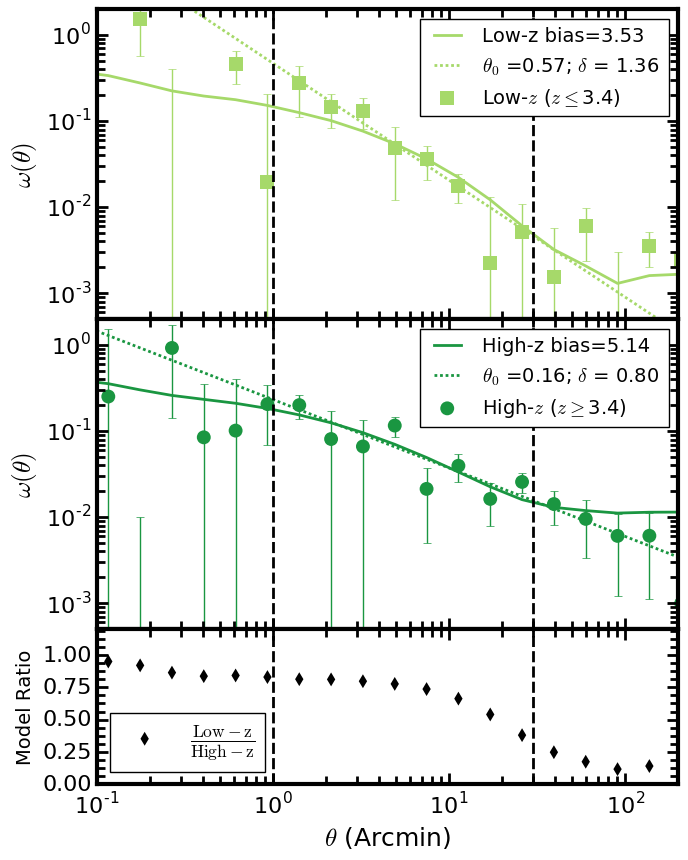

In [272]:
##Plot the different redshifts
from matplotlib import gridspec

#Plot for paper
fig = plt.figure(6,figsize = (15,10))
gs = gridspec.GridSpec(3, 1, width_ratios=[1,1],height_ratios = [1,1,0.5])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharex = ax0)
ax2 = plt.subplot(gs[2],sharex = ax0)

#BOSS
#ax0.scatter(Bth,Bwt,s=100,marker = '*', color = 'k',label = r'BOSS $2.2\leq z\leq 2.8$')
#lowz comparison to BOSS
ax0.scatter(separation[1],wnames[1],s = 100,color='#a6d96a',marker = 's', edgecolor='None',label=r'Low-$z$ ($z\leq$3.4)')
ax0.errorbar(separation[1],wnames[1],yerr=sigma[1]**0.5,elinewidth=1,fmt=',',color='#a6d96a')
ax0.plot(separation[1],Lls,linewidth = 2,color = '#a6d96a',label='Low-z bias=%0.2f'%lowzb[0])
#ax0.plot(separation[1],Ll,linewidth = 2,color = '#a6d96a',label='Low-z bias=%s'%lowzbias)
ax0.plot(separation[1],lowpow,color='#a6d96a',linewidth = 2, linestyle = ':',dashes = (2,2,2,2),label = r'$\theta_0$ =%0.2f; $\delta$ = %0.2f '%(lpfit[0],lpfit[1]))

ax0.axvline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax0.axvline(30,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')

ax0.set_ylim(5*10**-4,2)
ax0.set_yscale('log')
ax0.set_ylabel(r'$\omega (\theta)$',fontsize = 18)
ax0.legend(fontsize = 14, scatterpoints=1)


#He less luminous
#ax1.scatter(heth,hewll,s = 100,color='c', marker = '^',edgecolor='None',label='HSC $3\leq z\leq 4$')
#ax1.errorbar(heth,hewll,yerr=hewell,elinewidth=1,fmt=',',color='c')
#ax1.plot(heth,6.53/60.**0.86*heth**-0.86,color='c',linewidth = 2, linestyle = '--',dashes = (4,2,4,2))

#highz candidates comparison to HE
ax1.scatter(separation[2],wnames[2],s = 100,color = '#1a9641', marker = 'o',edgecolor='None',label=r'High-$z$ ($z\geq$3.4)')
ax1.errorbar(separation[2],wnames[2],yerr=sigma[2]**0.5,elinewidth=1,fmt=',',color='#1a9641')
ax1.plot(separation[1],Lhs,linewidth = 2,color = '#1a9641',label='High-z bias=%0.2f'%highzb[0])
#ax1.plot(separation[1],Ll,linewidth = 2,color = '#1a9641',label='Low-z bias=%s'%highzbias)
ax1.plot(separation[1],highpow,color='#1a9641',linewidth = 2, linestyle = ':',dashes = (2,2,2,2),label = r'$\theta_0$ =%0.2f; $\delta$ = %0.2f '%(hpfit[0],hpfit[1]))
ax1.axvline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax1.axvline(30,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')

ax1.set_ylim(5*10**-4,2)
ax1.set_yscale('log')
ax1.set_ylabel(r'$\omega (\theta)$',fontsize = 18)
ax1.legend(fontsize = 14, scatterpoints=1)

#ratio of the models in the high and low z case
ax2.scatter(separation[1],Lls/Lhs,marker = 'd', s = 50, color='k', edgecolor='None', label = r'$\frac{\rm{Low-}z}{\rm{High-}z}$')
ax2.axvline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax2.axvline(30,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')

ax2.set_ylabel(r'Model Ratio',fontsize = 14)
ax2.yaxis.set_ticks([0,0.25,0.5,0.75,1])
ax2.minorticks_on()
ax2.legend(fontsize = 18, scatterpoints = 1,loc = 3)

plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlim(0.1,200)
plt.xscale('log')
plt.xlabel(r'$\theta$ (Arcmin)',fontsize = 18)
#plt.ylabel(r'$\omega (\theta)$',fontsize = 18)

#plt.savefig('./corrfunc_zsplit.pdf',bbox_inches='tight')



plt.show()

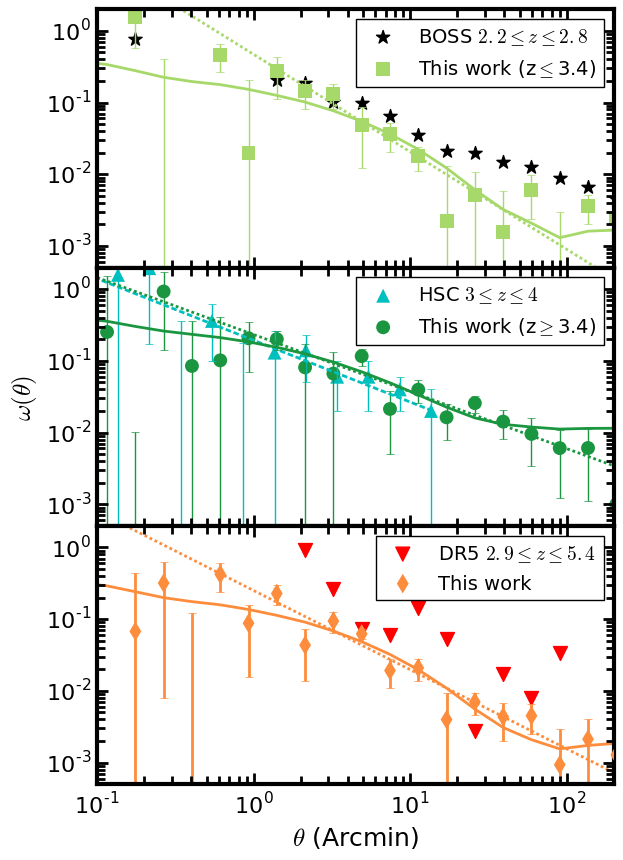

In [266]:
from matplotlib import gridspec
#Plotting Parameters (Replace with Group code call!)
params = {'legend.fontsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':8, 'xtick.minor.size':6, 'ytick.major.size':8, 'ytick.minor.size':6}
plt.rcParams.update(params)
plt.rc("axes", linewidth=3.0)

#Plot for paper
fig = plt.figure(4,figsize = (20,10))
gs = gridspec.GridSpec(3, 1, width_ratios=[1,1,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharex = ax0)
ax2 = plt.subplot(gs[2],sharex = ax0)

#BOSS
ax0.scatter(Bth,Bwt,s=100,marker = '*', color = 'k',label = r'BOSS $2.2\leq z\leq 2.8$')
#lowz comparison to BOSS
ax0.scatter(separation[1],wnames[1],s = 100,color='#a6d96a',marker = 's', edgecolor='None',label=r'This work (z$\leq$3.4)')
ax0.errorbar(separation[1],wnames[1],yerr=sigma[1]**0.5,elinewidth=1,fmt=',',color='#a6d96a')
ax0.plot(separation[1],Lls,linewidth = 2,color = '#a6d96a')#,label='Low-z bias=%0.2f'%lowzb[0])
#ax0.plot(separation[1],Ll,linewidth = 2,color = '#a6d96a',label='Low-z bias=%s'%lowzbias)
ax0.plot(separation[1],lowpow,color='#a6d96a',linewidth = 2, linestyle = ':',dashes = (2,2,2,2))#,label = r'$\theta_0$ =%0.2f ; $\delta$ = %0.2f '%(lpfit[0],lpfit[1]))


ax0.set_ylim(5*10**-4,2)
ax0.set_yscale('log')
#ax0.set_ylabel(r'$\omega (\theta)$',fontsize = 18)
ax0.legend(fontsize = 14, scatterpoints=1)


#He less luminous
ax1.scatter(heth,hewll,s = 100,color='c', marker = '^',edgecolor='None',label='HSC $3\leq z\leq 4$')
ax1.errorbar(heth,hewll,yerr=hewell,elinewidth=1,fmt=',',color='c')
ax1.plot(heth,6.53/60.**0.86*heth**-0.86,color='c',linewidth = 2, linestyle = '--',dashes = (4,2,4,2))

#highz candidates comparison to HE
ax1.scatter(separation[2],wnames[2],s = 100,color = '#1a9641', marker = 'o',edgecolor='None',label='This work (z$\geq$3.4)')
ax1.errorbar(separation[2],wnames[2],yerr=sigma[2]**0.5,elinewidth=1,fmt=',',color='#1a9641')
ax1.plot(separation[1],Lhs,linewidth = 2,color = '#1a9641')#,label='High-z bias=%0.2f'%highzb[0])
#ax1.plot(separation[1],Ll,linewidth = 2,color = '#1a9641',label='Low-z bias=%s'%highzbias)
ax1.plot(separation[1],highpow,color='#1a9641',linewidth = 2, linestyle = ':',dashes = (2,2,2,2))#,label = r'$\theta_0$ =%0.2f ; $\delta$ = %0.2f '%(hpfit[0],hpfit[1]))

ax1.set_ylim(5*10**-4,2)
ax1.set_yscale('log')
ax1.set_ylabel(r'$\omega (\theta)$',fontsize = 18)
ax1.legend(fontsize = 14, scatterpoints=1)


#Shen data
ax2.scatter(sth,sw,s=100,marker = 'v', color = 'r',label = r'DR5 $2.9\leq z\leq 5.4$ ')
#ax2.errorbar(sth,sw,yerr=sjk**0.5,elinewidth=1,fmt=',',color='r')
#full candidate list
ax2.scatter(separation[0],wnames[0],s = 100,color='#fd8d3c', marker = 'd',edgecolor='None',label=r'This work',zorder = 100)
ax2.errorbar(separation[0],wnames[0],yerr=sigma[0]**0.5,elinewidth=2,fmt=',',color='#fd8d3c')
#With Stellar contamination in fit
ax2.plot(separation[0],Las,linewidth = 2,color = '#fd8d3c')#,label = 'Stellar contamination\n b=%0.2f'%allzb[0])
#Power law fit
ax2.plot(separation[0],allpow,color='#fd8d3c',linewidth = 2, linestyle = ':',dashes = (2,2,2,2))#,label = r'$\theta_0$ =%0.2f ; $\delta$ = %0.2f '%(apfit[0],apfit[1]))

ax2.set_ylim(5*10**-4,2)
ax2.set_yscale('log')
#ax2.set_ylabel(r'$\omega (\theta)$',fontsize = 18)
ax2.legend(fontsize = 14, scatterpoints=1)



plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlim(0.1,200)
plt.xscale('log')
plt.xlabel(r'$\theta$ (Arcmin)',fontsize = 18)
#plt.ylabel(r'$\omega (\theta)$',fontsize = 18)


#plt.savefig('./comparison_corrfunc.pdf',bbox_inches='tight')
#fig.tight_layout()

plt.show()


## Set up and plot bias v redshift

In [267]:
#Biases from different surveys
### He 2017
bhe = 5.93
behe= 1.43
zhe = 3.8

### ROSS 2009
b = [2.06,1.41,1.38,1.45,1.83,2.37,1.92,2.42,2.79,3.62,2.99]
be = [0.03,0.18,0.06,0.38,0.33,0.25,0.5,0.4,0.47,0.49,1.42]
z = [1.27,0.24,0.49,0.80,1.03,1.23,1.41,1.58,1.74,1.92,2.10]

##SHEN 2007 Biases
#sb = [9.8,11.4,13.7]
#sz = [3,3.5,4]
sb = [7.9,14.2]
sbe = [0.8,1.4]
sz = [3,4]

### EFTEKHARZADEH
eb = [3.69,3.55,3.57]
ebe = [0.11,0.15,0.09]
ez = [2.297,2.497,2.971]

#### HOPKINS 2007 MODELS

maxdatH07 = open('./Hopkins07_clstr_maximal.dat','rw')
defdatH07 = open('./Hopkins07_clstr_default.dat','rw')
extdatH07 = open('./Hopkins07_clstr_extreme_feedback.dat','rw')

maxH07 = maxdatH07.readlines()
defH07 = defdatH07.readlines()
extH07 = extdatH07.readlines()


zH07 = []
bmH07 = []
bdH07 = []
beH07 = []

b20mH07 = []
b20eH07 = []
b20dH07 = []

for i in range(len(maxH07)):
    valm=maxH07[i].split()
    vald=defH07[i].split()
    vale=extH07[i].split()
    zH07.append(np.float(valm[0]))
    bmH07.append(np.float(valm[1]))
    bdH07.append(np.float(vald[1]))
    beH07.append(np.float(vale[1]))
    b20mH07.append(np.float(valm[3]))
    b20eH07.append(np.float(vale[3]))
    b20dH07.append(np.float(vald[3]))
    


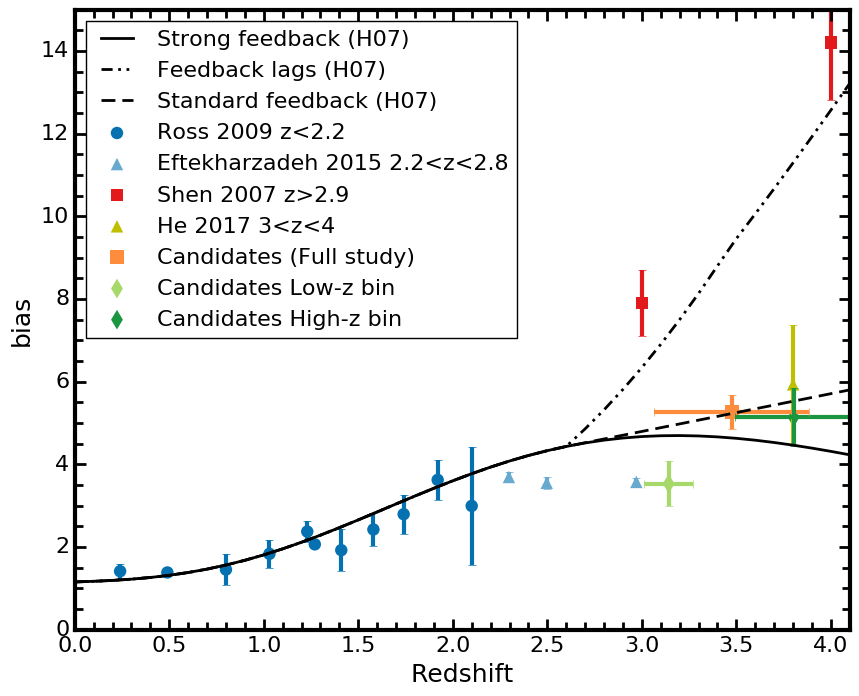

In [269]:
plt.figure(5,figsize=(10,8))
#ax1 = fig.add_subplot(1,1,1)

plt.scatter(z,b,s=80,c='#0571b0', marker = 'o', edgecolor = 'none', label='Ross 2009 z<2.2')
plt.errorbar(z,b,yerr=be,color='#0571b0', fmt=',',linewidth=3)

plt.scatter(ez,eb,s=80,c='#67a9cf', marker = '^',edgecolor = 'none', label='Eftekharzadeh 2015 2.2<z<2.8')
plt.errorbar(ez,eb,yerr=ebe,color='#67a9cf', fmt=',',linewidth=3)

plt.scatter(sz,sb,s=80,c='#e31a1c', marker = 's',edgecolor = 'none', label='Shen 2007 z>2.9')
plt.errorbar(sz,sb,yerr=sbe,color='#e31a1c', fmt=',',linewidth=3)

plt.scatter(zhe,bhe,s=80,c='y', marker = '^',edgecolor = 'none', label='He 2017 3<z<4')
plt.errorbar(zhe,bhe,yerr=behe,color='y', fmt=',',linewidth=3)

'''
#No stellar contam
plt.scatter(3.479,allzbias, marker = 'd',c='#ca0020', s=100, edgecolor = 'none', label = 'Candidates')
plt.errorbar(3.479,allzbias,yerr=0.22878057**0.5,color='#ca0020', fmt=',',linewidth=3)

plt.scatter(3.143,lowzbias, marker = 'd',c='#ca0020', s=100, edgecolor = 'none')
plt.errorbar(3.143,lowzbias,yerr=0.60656223**0.5,color='#ca0020', fmt=',',linewidth=3)

plt.scatter(3.803,highzbias, marker = 'd',c='#ca0020', s=100, edgecolor = 'none')
plt.errorbar(3.803,highzbias,yerr=0.50286617**0.5,color='#ca0020', fmt=',',linewidth=3)
'''

#Stellar contam
plt.scatter(3.476,allzb[0], marker = 's',c='#fd8d3c', s=100, edgecolor = 'none', label = 'Candidates (Full study)')
plt.errorbar(3.476,allzb[0],xerr= 0.41, yerr=allzcov[0][0]**0.5,color='#fd8d3c', fmt=',',linewidth=3)

plt.scatter(3.142,lowzb[0], marker = 'd',c='#a6d96a', s=100, edgecolor = 'none', label = 'Candidates Low-z bin')
plt.errorbar(3.142,lowzb[0],xerr=0.13 ,yerr=lowzcov[0][0]**0.5,color='#a6d96a', fmt=',',linewidth=3)

plt.scatter(3.803,highzb[0], marker = 'd',c='#1a9641', s=100, edgecolor = 'none', label = 'Candidates High-z bin')
plt.errorbar(3.803,highzb[0],xerr=0.31 , yerr=highzcov[0][0]**0.5,color='#1a9641', fmt=',',linewidth=3)

#plt.plot(zH07,b20mH07, linewidth = 2, linestyle='-', color='c',label = "i < 20.2 degeneracy")
plt.plot(zH07,beH07, linewidth = 2, linestyle='-', color='k',label = "Strong feedback (H07)")
plt.plot(zH07,bmH07, linewidth = 2, linestyle='-.', color='k',dashes = (8,4,2,4,2,4), label = "Feedback lags (H07)")
plt.plot(zH07,bdH07, linewidth = 2, linestyle='--', dashes = (10,5,10,5), color='k',label = "Standard feedback (H07)")

#plt.plot(zH07,b20mH07, linewidth = 2, linestyle=':', c='k',dashes = (3,2,3,2), label = r"All feedback models at $i$<20.2 (H07)")
#plt.plot(zH07,b20eH07, linewidth = 2, linestyle=':', c='k',dashes = (3,2,3,2), label = r"$i$=20.2 (H07)")
#plt.plot(zH07,b20dH07, linewidth = 2, linestyle=':', c='k',dashes = (3,2,3,2), label = r"Feedback models with $i$=20.2 (H07)")

plt.xlabel('Redshift',fontsize = 18)
plt.ylabel('bias',fontsize = 18)
plt.ylim(0,15)
plt.xlim(0,4.1)
plt.legend(loc = 2, scatterpoints=1)
plt.minorticks_on()
#plt.savefig('./Bais_v_Redshift_paper.pdf')
plt.show()

## Plot the regression matrix

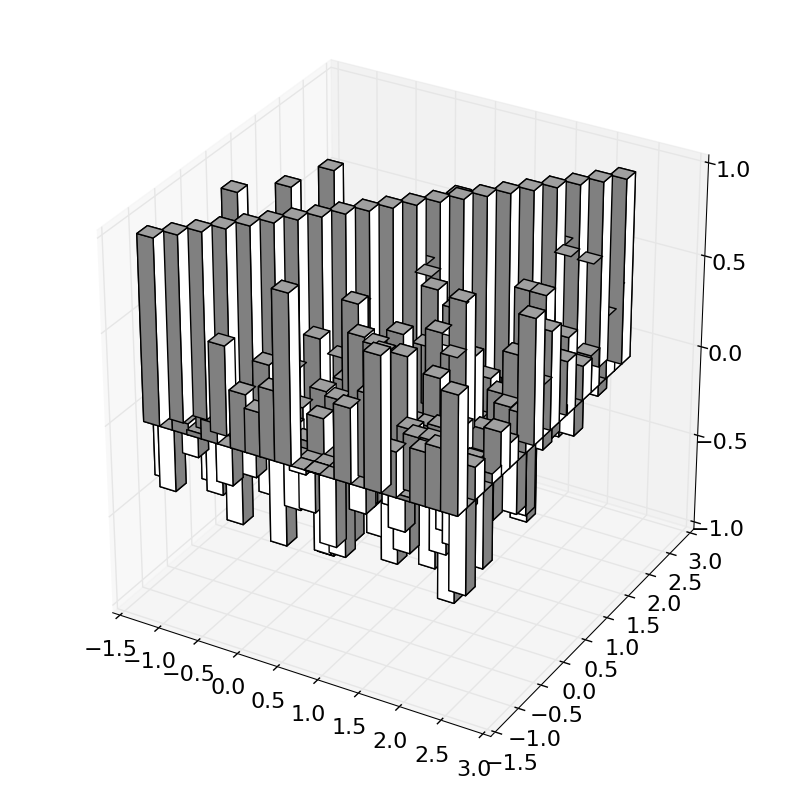

In [93]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(6,figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

# Construct arrays for the anchor positions of the 16 bars.
# Note: np.meshgrid gives arrays in (ny, nx) so we use 'F' to flatten xpos,
# ypos in column-major order. For numpy >= 1.7, we could instead call meshgrid
# with indexing='ij'.
X,Y = np.meshgrid(np.log10(th),np.log10(th))
xpos = X.flatten('F')
ypos = Y.flatten('F')
zpos = np.zeros_like(xpos)

# Construct arrays with the dimensions for the 16 bars.
dx = 0.2*np.ones_like(zpos)
dy = dx.copy()
dz = regmat[0].flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='w', zsort='average')
ax.set_zlim(-1,1)

plt.show()

In [ ]:
## Plot the Colors of the candidates

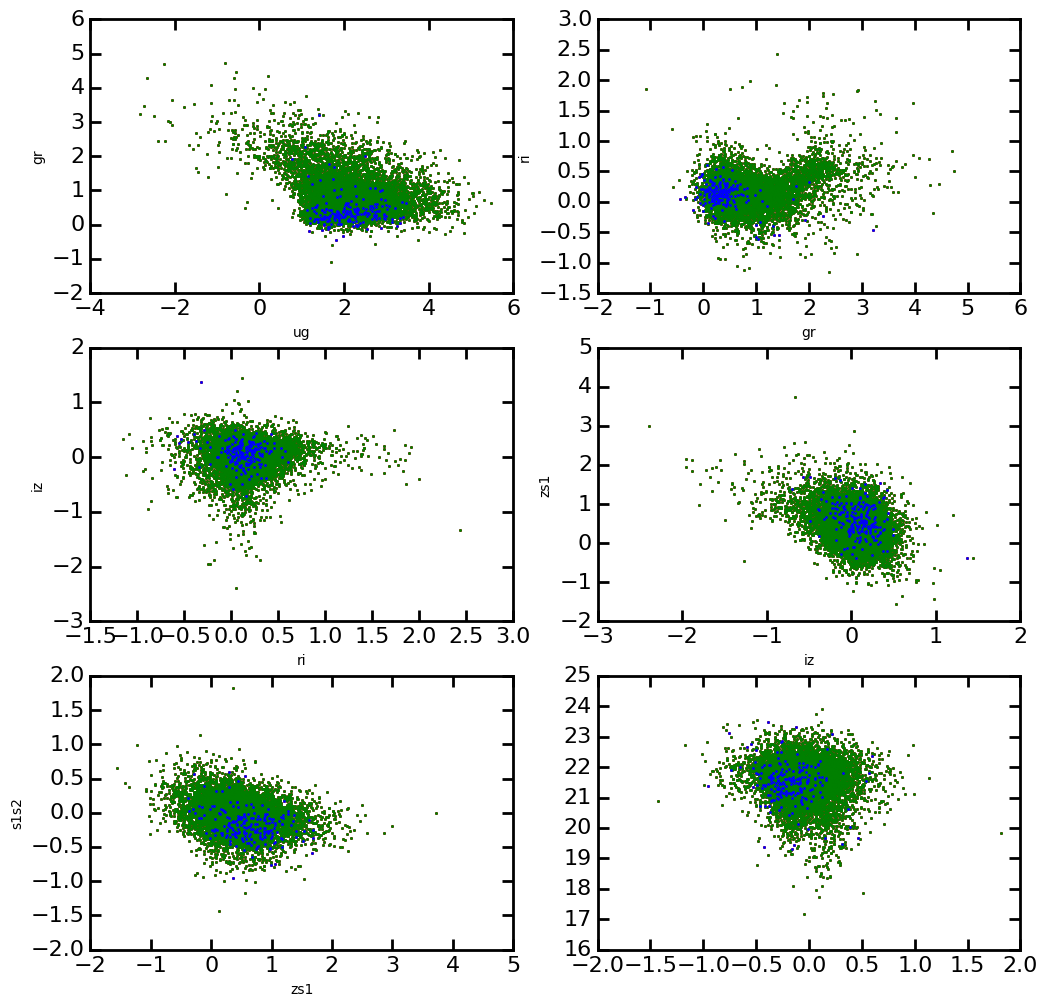

In [156]:
from astropy.table import Table

file1='../Data_Sets/QSO_Candidates_allcuts_with_errors_visualinsp.fits'
data = Table.read(file1)

#Plotting Parameters (Replace with Group code call!)
params = {'legend.fontsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':8, 'xtick.minor.size':6, 'ytick.major.size':8, 'ytick.minor.size':6}
plt.rcParams.update(params)
plt.rc("axes", linewidth=2.0)

ddx = ()
dx = (data['Good_obj']==0)
dddx= (data['Good_obj']==1)
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize = (12,12))#, sharex='col', sharey='row')
#f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.scatter(data['ug'],data['gr'], s = 1, color = 'k')
ax1.scatter(data['ug'][ddx],data['gr'][ddx], s = 1, color = 'r')
ax1.scatter(data['ug'][dx],data['gr'][dx], s = 1, color = 'g')
ax1.scatter(data['ug'][dddx],data['gr'][dddx], s = 1, color = 'b')

ax1.set_xlabel('ug')
ax1.set_ylabel('gr')

ax2.scatter(data['gr'],data['ri'], s = 1, color = 'k')
ax2.scatter(data['gr'][ddx],data['ri'][ddx], s = 1, color = 'r')
ax2.scatter(data['gr'][dx],data['ri'][dx], s = 1, color = 'g')
ax2.scatter(data['gr'][dddx],data['ri'][dddx], s = 1, color = 'b')

ax2.set_xlabel('gr')
ax2.set_ylabel('ri')

ax3.scatter(data['ri'],data['iz'], s = 1, color = 'k')
ax3.scatter(data['ri'][ddx],data['iz'][ddx], s = 1, color = 'r')
ax3.scatter(data['ri'][dx],data['iz'][dx], s = 1, color = 'g')
ax3.scatter(data['ri'][dddx],data['iz'][dddx], s = 1, color = 'b')

ax3.set_xlabel('ri')
ax3.set_ylabel('iz')

ax4.scatter(data['iz'],data['zs1'], s = 1, color = 'k')
ax4.scatter(data['iz'][ddx],data['zs1'][ddx], s = 1, color = 'r')
ax4.scatter(data['iz'][dx],data['zs1'][dx], s = 1, color = 'g')
ax4.scatter(data['iz'][dddx],data['zs1'][dddx], s = 1, color = 'b')

ax4.set_xlabel('iz')
ax4.set_ylabel('zs1')

ax5.scatter(data['zs1'],data['s1s2'], s = 1, color = 'k')
ax5.scatter(data['zs1'][ddx],data['s1s2'][ddx], s = 1, color = 'r')
ax5.scatter(data['zs1'][dx],data['s1s2'][dx], s = 1, color = 'g')
ax5.scatter(data['zs1'][dddx],data['s1s2'][dddx], s = 1, color = 'b')

ax5.set_xlabel('zs1')
ax5.set_ylabel('s1s2')


ax6.scatter(data['s1s2'],22.5-2.5*np.log10(data['iflux']), s = 1, color = 'k')
ax6.scatter(data['s1s2'][ddx],22.5-2.5*np.log10(data['iflux'][ddx]), s = 1, color = 'r')
ax6.scatter(data['s1s2'][dx],22.5-2.5*np.log10(data['iflux'][dx]), s = 1, color = 'g')
ax6.scatter(data['s1s2'][dddx],22.5-2.5*np.log10(data['iflux'][dddx]), s = 1, color = 'b')

plt.show()